#  Walmart

## <span style="color:red"><b>TODO & Ideas - TO BE COMMENTED</b></span>

* Smarter imputing
* Supprimer des groupes et voir ce que cela donne avec les autres features seules
    * Remove store 
    * Remove Dateset mois. Regarder alors
* Mois, Jours, ans as categories
* ~~use PCA~~
* RidgeCV, LassoCV ?
* ElasticNet
* ~~Compter le nombre de outliers avant des les virer ?~~
* ~~Faire test : Virer les outliers AVANT de faire les imputation~~
  * ~~Faudra median ou mean dans les imputations~~

# Preface

## Executive summary
* In 2001 Michele BANKO and Eric BRILL (Microsoft) talked about the [unreasonable effectiveness of data](https://dl.acm.org/doi/10.3115/1073012.1073017).
* With less than 150 observations, 10% of the target missing and 7 features it is not a surprise if the results are somewhat disapointing but again it is all about trade-off 
* With a Lasso Regularized Linear Regression 
    * The model is still overfitting (R² goes from 0.97 to 0.90 between train & test) 
    * MAPE (Mean Absolute Percentage Error) in testing is twice the value of training (15% vs 8%)
* Grouping stores by revenue and canceling some of the features "by hand" (acting more or less like a Lasso regularization) we were able to reduce significantly the overfit but at the cost of accuracy in predictions (MAPE). 
    * R² remains constant between train & test (0.88) 
    * However, MAPE metric deteriorated from 15% to 19% 

To make a long story short, we can :
* Get 15% of difference between predictions & real values **but** the model is overfitting 
* Get 19% of difference between predictions & real values **with** no overfitting. 

Our <span style="color:orange"><b>recommendations</b></span> are :
1. Get more data in order to improve the model 
1. Start with option 2 (19% of difference, no overfit) if we really need to

## Notes about specifications

1. Part 1 
    * EDA 
    * Create some visualizations
    * Make all the necessary preprocessings to prepare data for machine learning
        * Drop lines where target values are missing
        * Create usable features from the Date column. create the features : year, month, day, day of week
        * Drop lines containing invalid values or outliers. $[\bar{X} - 3\sigma, \bar{X} + 3\sigma]$. Temperature, Fuel_price, CPI (Consumer Price Index), Unemployment
    * target variable = Weekly_Sales
    * Categorical variables : Store, Holiday_Flag
    * Numerical variables : Temperature, Fuel_Price, CPI, Unemployment, Year, Month, Day, DayOfWeek

1. Part 2 
    * Train a linear regression model (baseline)
    * Assess the performances of the model by using a metric that is relevant for regression problems
        * Are you satisfied with the results ?
        * Print the values of the model's coefficients to know what features are important for the prediction
        * use the `.coef_` attribute of scikit-learn's LinearRegression class
        * https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    * Interpret the coefficients of the model to identify what features are important for the prediction

1. Part 3  
    * Train at least one model with regularization (Lasso or Ridge) to reduce overfitting
        * https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
        * https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso

1. Bonus 
    * GridSearchCV 
    * hyperparameter "the regularization strength"  
    * https://alfurka.github.io/2018-11-18-grid-search/


In [44]:
# prelude

import pandas             as pd
import numpy              as np
import seaborn            as sns
import matplotlib.pyplot  as plt

from sklearn.model_selection    import train_test_split, GridSearchCV 
from sklearn.pipeline           import make_pipeline
from sklearn.impute             import SimpleImputer
from sklearn.preprocessing      import OneHotEncoder, StandardScaler    
from sklearn.compose            import make_column_transformer                  
from sklearn.linear_model       import LinearRegression, Lasso, Ridge
from sklearn.metrics            import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition      import PCA

from pathlib import Path
# k_CurrentDir = Path(__file__).parent # __file__ is not known in Jupyter context
k_Current_dir = Path.cwd()

k_AssetsDir     = "assets"
k_FileName      = "walmart_store_sales.csv"
k_FileNameOut   = "df_after-pre-preprocessing.csv"
k_Gold          = 1.618         # gold number for ratio
k_Width         = 12
k_Height        = k_Width/k_Gold
k_target        = "weekly_sales"
k_random_state  = 42           
k_test_size     = 20/100        

# Part 1 : EDA

## Exploring the dataset

In [45]:
filename_in  = k_Current_dir/k_AssetsDir/k_FileName
df = pd.read_csv(filename_in)

df.columns = df.columns.str.lower()
df.head(10)

,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896
6,15.0,03-06-2011,695396.19,0.0,69.80,4.069,134.855161,7.658
7,20.0,03-02-2012,2203523.20,0.0,39.93,3.617,213.023622,6.961
8,14.0,10-12-2010,2600519.26,0.0,30.54,3.109,NaN,NaN
9,3.0,NaN,418925.47,0.0,60.12,3.555,224.132020,6.833


* The target is : ``weekly_sales``

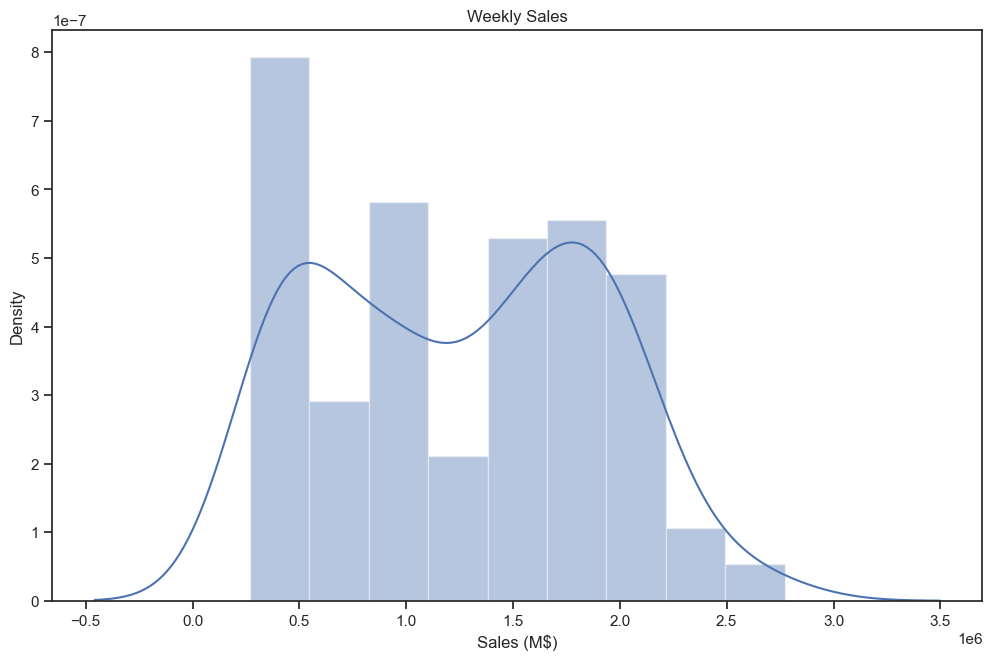

In [46]:
fig, ax = plt.subplots(figsize=(k_Width, k_Height))
sns.histplot(df["weekly_sales"], kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4)) 
ax.set_title("Weekly Sales")
_ = ax.set_xlabel("Sales (M$)")


### <span style="color:orange"><b>Comments :</b></span>

* This is not what one could call a well rounded bell curve...
* It would be nice to take the year into account
* This is NOT yet the case here 
* Looks like kind of bi modal but we cannot say if it is due to changes over the years for example

In [47]:
print(f"The dataset consists of :")
print(f"\t{len(df.shape):>6_} dimensions")
print(f"\t{df.shape[0]:>6_} observations (lines)")
print(f"\t{df.shape[1]:>6_} features     (target not yet splitted)")

The dataset consists of :
	     2 dimensions
	   150 observations (lines)
	     8 features     (target not yet splitted)


### <span style="color:orange"><b>Comments :</b></span>
* Only 150 observations for 1 target and 7 features
* It would be better to get at least 210 observations (30*7)

In [48]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
store,150.0,9.866667e+00,6.231191,1.000000,4.000000,9.000000e+00,1.575000e+01,2.000000e+01
weekly_sales,136.0,1.249536e+06,647463.042349,268929.030000,605075.717500,1.261424e+06,1.806386e+06,2.771397e+06
holiday_flag,138.0,7.971014e-02,0.271831,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
temperature,132.0,6.139811e+01,18.378901,18.790000,45.587500,6.298500e+01,7.634500e+01,9.165000e+01
fuel_price,136.0,3.320853e+00,0.478149,2.514000,2.852250,3.451000e+00,3.706250e+00,4.193000e+00
cpi,138.0,1.798985e+02,40.274956,126.111903,131.970831,1.979089e+02,2.149346e+02,2.269688e+02
unemployment,135.0,7.598430e+00,1.577173,5.143000,6.597500,7.470000e+00,8.150000e+00,1.431300e+01


In [49]:
types_df = pd.DataFrame ({
  "types" : df.dtypes.value_counts()
})
types_df["as_%"] = (100 * types_df["types"]/types_df["types"].sum()).round(2)

display(types_df)

,types,as_%
float64,7,87.5
object,1,12.5


In [50]:
print(f"The dataset contains {df.duplicated().sum()} duplicated observations.")

The dataset contains 0 duplicated observations.


In [51]:

# -----------------------------------------------------------------------------
def quick_View(df):
  summary_lst = []
  
  for col_name in df.columns:
    col_dtype               = df[col_name].dtype
    num_of_null             = df[col_name].isnull().sum()
    percent_of_null         = num_of_null/len(df)
    num_of_non_null         = df[col_name].notnull().sum()
    num_of_distinct_values  = df[col_name].nunique()
    
    if num_of_distinct_values <= 10:
        distinct_values_counts = df[col_name].value_counts().to_dict()
    else:
        top_10_values_counts    = df[col_name].value_counts().head(10).to_dict()
        distinct_values_counts  = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

    if col_dtype != "object":
       max_of_col = df[col_name].max()
       min_of_col = df[col_name].min()
       outlier_hi = df[col_name].mean() + 3*df[col_name].std()
       outlier_lo = df[col_name].mean() - 3*df[col_name].std()
    else:
       max_of_col = -1
       min_of_col =  1
       outlier_hi = -1
       outlier_lo =  1
    
    summary_lst.append({
      "name"                : col_name,
      "dtype"               : col_dtype,
      "# null"              : num_of_null,
      "% null"              : (100*percent_of_null).round(2),
      "# NOT null"          : num_of_non_null,
      "distinct val"        : num_of_distinct_values,
      "-3*sig"              : round(outlier_lo,2) ,
      "min"                 : round(min_of_col,2),
      "max"                 : round(max_of_col,2),
      "+3*sig"              : round(outlier_hi,2) ,
      "distinct val count"  : distinct_values_counts
    })
  
  tmp_df = pd.DataFrame(summary_lst)
  return tmp_df

In [52]:
tmp_df = quick_View(df)
display(tmp_df.sort_values(by="# null", ascending=False))                 

,name,dtype,# null,% null,# NOT null,distinct val,-3*sig,min,max,+3*sig,distinct val count
1,date,object,18,12.00,132,85,1.00,1.00,-1.00,-1.00,"{'19-10-2012': 4, '07-01-2011': 4, '16-03-2012..."
4,temperature,float64,18,12.00,132,130,6.26,18.79,91.65,116.53,"{52.77: 2, 68.91: 2, 59.61: 1, 82.7: 1, 83.52:..."
7,unemployment,float64,15,10.00,135,104,2.87,5.14,14.31,12.33,"{8.15: 4, 6.664: 3, 6.832999999999998: 3, 6.31..."
2,weekly_sales,float64,14,9.33,136,136,-692853.30,268929.03,2771397.17,3191924.95,"{1572117.54: 1, 1799520.14: 1, 1494251.5: 1, 8..."
5,fuel_price,float64,14,9.33,136,120,1.89,2.51,4.19,4.76,"{3.594: 4, 3.63: 3, 2.78: 2, 2.637: 2, 2.548: ..."
3,holiday_flag,float64,12,8.00,138,2,-0.74,0.00,1.00,0.90,"{0.0: 127, 1.0: 11}"
6,cpi,float64,12,8.00,138,135,59.07,126.11,226.97,300.72,"{127.1917742: 2, 126.7934: 2, 129.2015806: 2, ..."
0,store,float64,0,0.00,150,20,-8.83,1.00,20.00,28.56,"{3.0: 15, 1.0: 11, 18.0: 10, 19.0: 9, 5.0: 9, ..."


### <span style="color:orange"><b>Comments :</b></span>
* Outliers only in `unemployment` (where 3 $\sigma$ < max)
* 2 different values in the ``holiday_flag`` feature
* 20 different values in the ``store`` feature

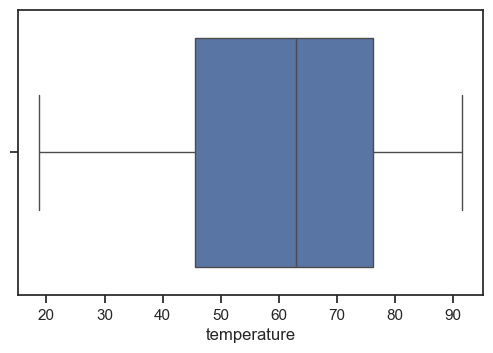

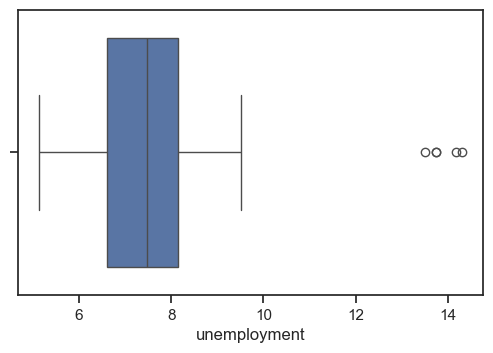

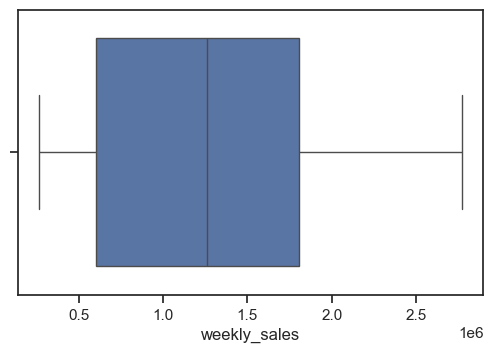

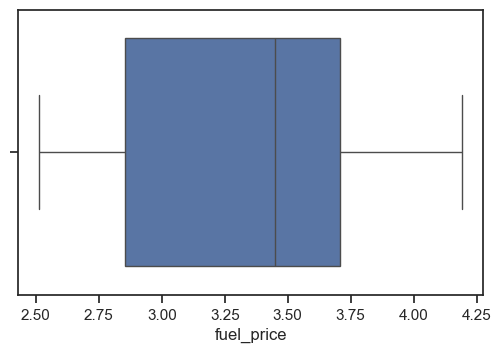

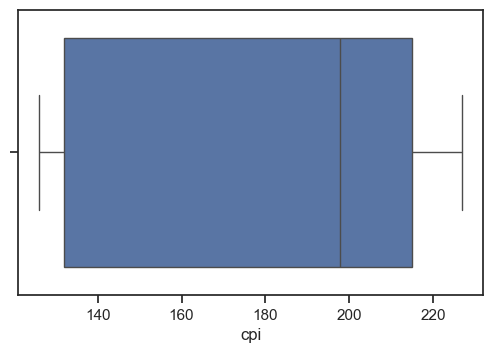

In [53]:
# Let's visualize outliers if any
# holiday_flag and store looks like categories and values are in specific range (review the output of quick_View() if needed)
col_outliers = ["temperature", "unemployment", "weekly_sales", "fuel_price", "cpi", ]

for col in col_outliers:
  fig, ax = plt.subplots(figsize=(k_Width/2, k_Height/2))
  sns.boxplot(df, x=col)

### <span style="color:orange"><b>Comments :</b></span>
* This confirm what we saw earlier within the output of quick_view()
* Outliers are only in the `unemployment` feature

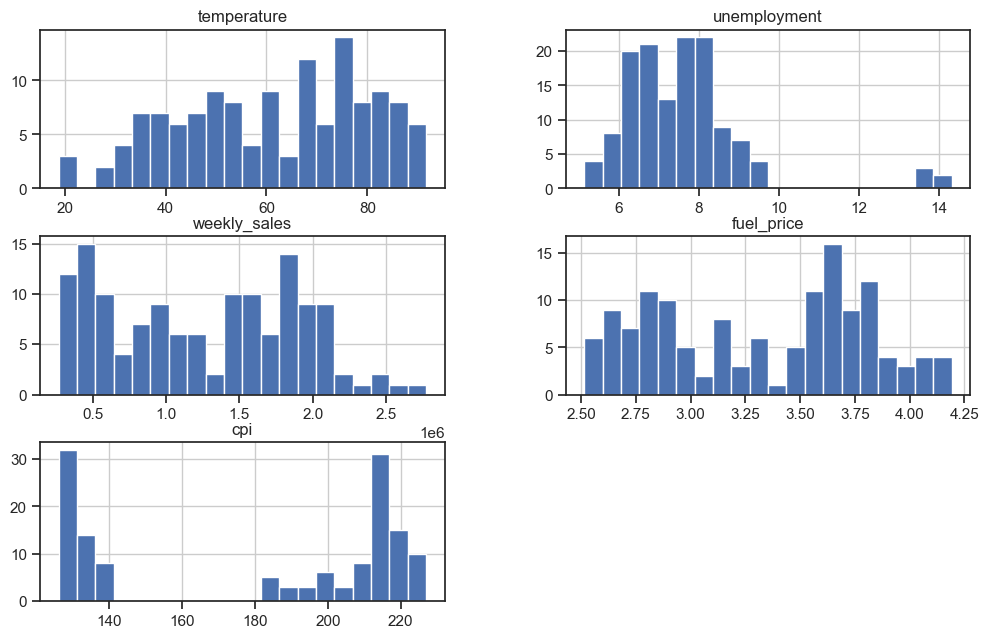

In [54]:
# How look the features distribution (including the target) ?
tmp_df = df[["temperature", "unemployment", "weekly_sales", "fuel_price", "cpi"]]
_ = tmp_df.hist(bins=20, figsize=(k_Width, k_Height))

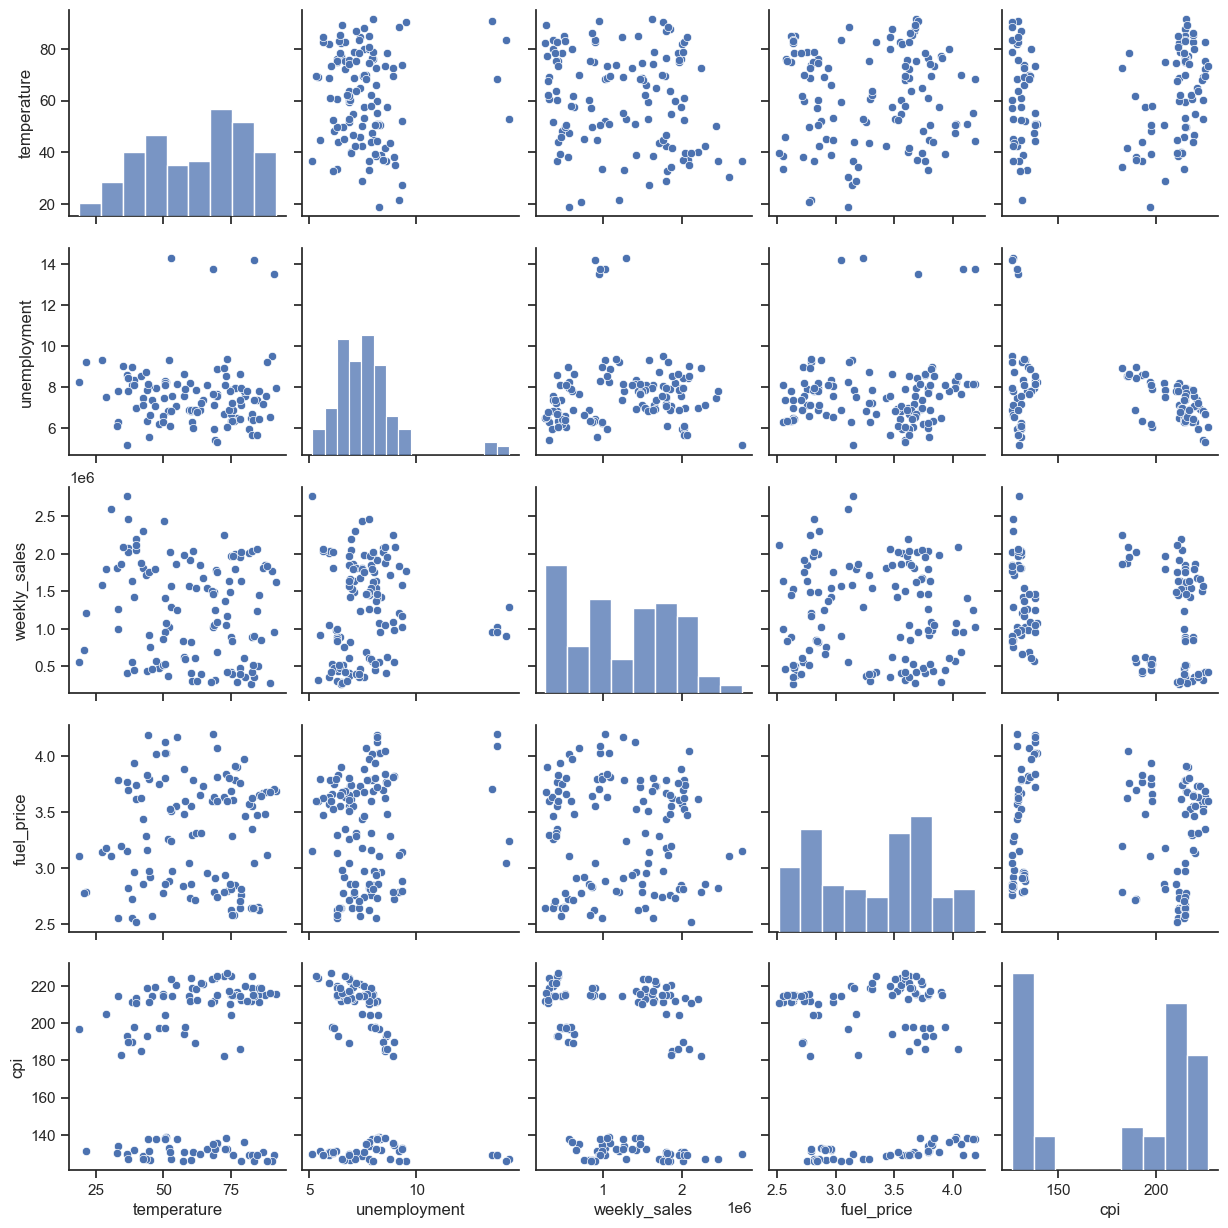

In [55]:
# Same question : how look the features distribution (including the target) ?
tmp_df = df[["temperature", "unemployment", "weekly_sales", "fuel_price", "cpi"]]
sns.set(style="ticks")
_ = sns.pairplot(tmp_df)

### <span style="color:orange"><b>Comments :</b></span>
* It seems there are 2 modes for `cpi`
* We can see the outliers in `unemployment`

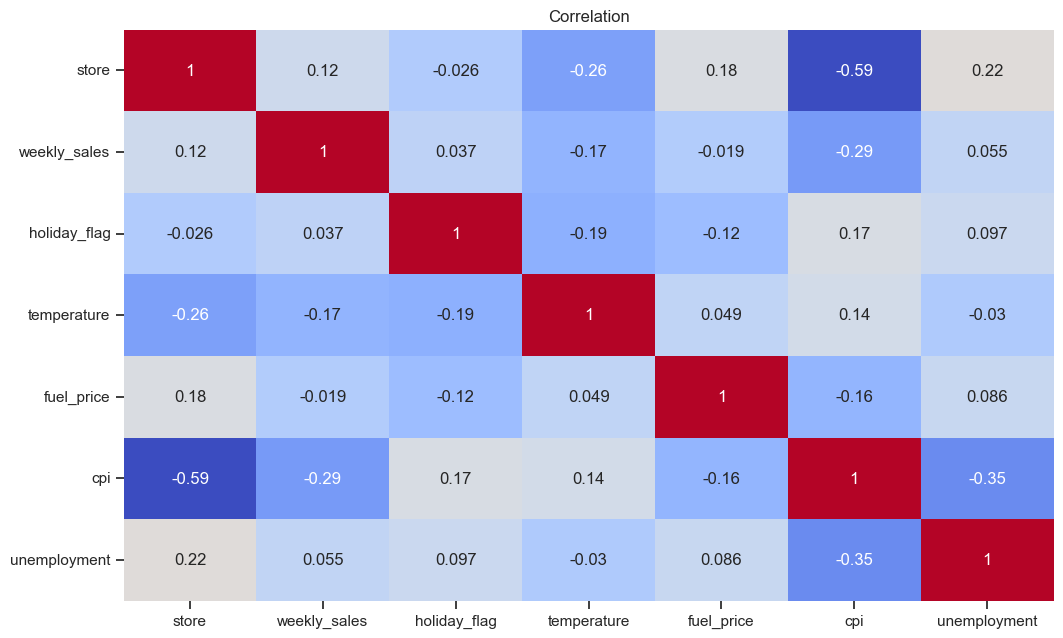

In [56]:
# The correlation matrix may help to find a good candidate for the baseline model (one feature)
correlation_matrix = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(k_Width, k_Height))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", cbar=False)
ax.set_title("Correlation");


* 12% of the dates are missing (quick_View())
* How are they distributed ?
* Might be important when selecting the imputing strategy

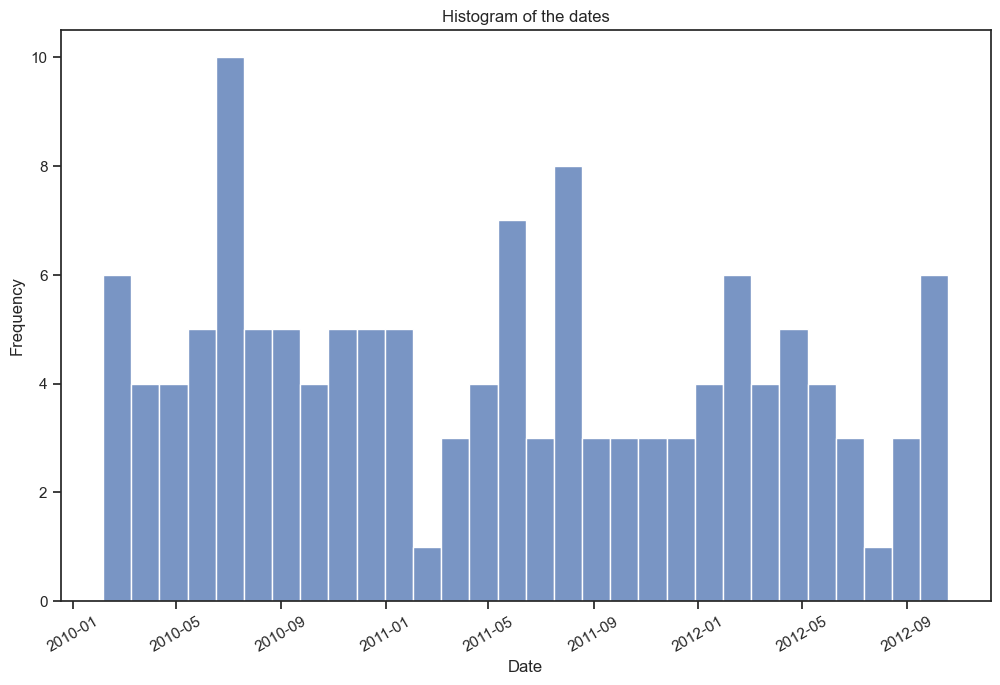

In [57]:
df_tmp = pd.DataFrame()
df_tmp['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df_tmp.dropna(inplace=True) 
df_tmp = df_tmp.sort_values(by='date')
# display(df_tmp)

fig, ax = plt.subplots(figsize=(k_Width, k_Height))
sns.histplot(df_tmp['date'], bins=30, kde=False)          # 30 months from 2010 02 to 2012 10
plt.xlabel('Date')
plt.xticks(rotation=30)
plt.ylabel('Frequency')
plt.title('Histogram of the dates')
plt.show()

### TODO

1. ``store`` to be converted into categories 
    * see quick_View() output
    * 20 disctincts values
1. ``holiday_flag`` to be converted to categories 
    * 2 distincts values
1. ``date to convert`` to date type
    * create : year, month, day, day of week
1. drop lines were the ``weekly_sales`` is empty
1. 12% of the ``dates`` are missing. 
    * The dataset is very small. 
    * Can't drop. 
    * Fill with **?????**
1. 12% of ``temperatures`` are missing. 
    * If for the same store, a date with the same month is available, replace with the temp 
    * Indeed, temp in april in Florida are not the same as temp in april in Alaska. 
    * If no month is available on the row then replace with the average temp for the store (as today Florida is still warmer than Alaska)
1. 10% of the ``unemployement`` values are missing. 
    * Fill with mean of the year
1.  9% of ``fuel_price`` values are missing. 
    * Replace with the median of the fuel_price for the store 
    * Not the average because outliers may not have been replaced yet
1.  8% of ``cpi`` (Consumer Price Index) values are missing. 
    * No way to know where the store is located
    * Replace with the median of the cpi for the store. 
    * It seems there are 2 modes. We could find which mode correspond to the store then apply the median of the mode  
1. Convert ``temperature`` to °C
1. Any outliers ? 
    * Let's do some testing to decide if we should remove outliers before or after imputation or execute impputation before removing outliers



## Preprocessing the dataset

### Pre preprocessing with pandas
* This preprocessing usually impact the complete lines 
* It is done BEFORE the split between target and features

TODO : 
1. drop lines were the ``weekly_sales`` is empty
1. Remove outliers 
1. ``store`` to be converted into categories 
    * see quick_View() output
    * 20 disctincts values
1. ``holiday_flag`` to be converted to categories 
    * 2 distincts values
1. ``date`` to convert to date type
    * create : year, month, day, day of week
1. Convert ``temperature`` to °C


In [58]:
# 4 - drop lines were the ``weekly_sales`` is empty
print(df.shape)
df = df.dropna(subset=["weekly_sales"])
print(df.shape)

(150, 8)
(136, 8)


In [59]:

# -----------------------------------------------------------------------------
def remove_Outliers_IQR(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[((df[column] >= lower_bound) & (df[column] <= upper_bound)) | df[column].isna()]
    return df


# -----------------------------------------------------------------------------
def remove_Outliers_Sigma(df, column):
    mean_col = df[column].mean()
    sigma_col = df[column].std()

    lower_bound = mean_col - 3 * sigma_col
    upper_bound = mean_col + 3 * sigma_col
    df = df[((df[column] >= lower_bound) & (df[column] <= upper_bound)) | df[column].isna()]
    return df

# -----------------------------------------------------------------------------
# method = "IQR" or "sigma"
def remove_Outliers(df, column, method="sigma"):
    match method:
        case "IQR":
            df = remove_Outliers_IQR(df, column)
        case "sigma":
            df = remove_Outliers_Sigma(df, column)
        case _:
            raise Exception("method must be IQR or sigma")    
    
    return df

print(df.shape)
for col in col_outliers:
    df = remove_Outliers(df, col, method="sigma")
print(df.shape)

(136, 8)
(131, 8)


In [60]:
# impute holiday_flag 
# MUST be done before holiday_flag is converted to category

# if a flag is not defined on the current row
# if a date is available on the current row 
# check in holiday_flag_by_dates if the date exits. If yes copy the value of the flag into the current row  
# if there is no date on the current row, then set the flag to 0 because there are more dates without holyday than dates with.   

holiday_flag_by_dates = df.groupby(["date"])["holiday_flag"].sum()

def impute_Holiday_Flag(row):
    if pd.isna(row["holiday_flag"]):
        date = row["date"]
        flag = holiday_flag_by_dates.get((date))
        if pd.notna(flag):
          return 1 if flag > 0 else 0 
        else:
          return 0
    else:
        return row["holiday_flag"]

df["holiday_flag"] = df.apply(impute_Holiday_Flag, axis=1)
# print(df["holiday_flag"].isnull().sum())
# display(df)

In [61]:
# 1 & 2 - Convert store a holiday_flag into categories

convert_to_cat = ["store", "holiday_flag"]

for col in convert_to_cat:
  # no missing value to handle we are good to go
  df[col] = df[col].astype("int").astype("str")


In [62]:
# 3 - Convert date & create year, month, day, day of week 

df["date"] = pd.to_datetime(df["date"], dayfirst=True)
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["weekday"] = df["date"].dt.weekday
df.drop(columns="date", inplace=True)


In [63]:
# 5 - convert ``temperature`` to °C

df["temperature_c"] = (df["temperature"] - 32.0)* 5.0/9.0
df.drop(columns="temperature", inplace=True)
df.rename(columns={"temperature_c" : "temperature"}, inplace=True)


In [64]:
tmp_df = quick_View(df)
display(tmp_df.sort_values(by="# null", ascending=False))     
df.to_csv(k_Current_dir/k_AssetsDir/k_FileNameOut)

,name,dtype,# null,% null,# NOT null,distinct val,-3*sig,min,max,+3*sig,distinct val count
6,year,float64,18,13.74,113,3,2008.36,2010.00,2012.00,2013.30,"{2010.0: 49, 2011.0: 34, 2012.0: 30}"
7,month,float64,18,13.74,113,12,-3.27,1.00,12.00,15.81,"{6.0: 14, 2.0: 12, 5.0: 12, 7.0: 12, 3.0: 10, ..."
8,day,float64,18,13.74,113,30,-8.19,1.00,31.00,41.25,"{12.0: 10, 19.0: 7, 25.0: 7, 18.0: 6, 16.0: 6,..."
9,weekday,float64,18,13.74,113,1,4.00,4.00,4.00,4.00,{4.0: 113}
5,unemployment,float64,14,10.69,117,96,4.42,5.14,9.52,10.38,"{6.832999999999998: 3, 8.15: 3, 5.644: 2, 6.10..."
10,temperature,float64,14,10.69,117,116,-15.00,-7.34,33.14,46.56,"{20.505555555555553: 2, 15.33888888888889: 1, ..."
3,fuel_price,float64,12,9.16,119,108,1.88,2.51,4.17,4.73,"{3.594: 3, 3.786: 2, 2.548: 2, 3.3080000000000..."
4,cpi,float64,11,8.40,120,119,61.01,126.11,226.97,299.35,"{126.7934: 2, 214.7775231: 1, 210.3374261: 1, ..."
0,store,object,0,0.00,131,19,1.00,1.00,-1.00,-1.00,"{'3': 12, '18': 10, '14': 9, '1': 9, '13': 9, ..."
1,weekly_sales,float64,0,0.00,131,131,-715248.52,268929.03,2771397.17,3231229.40,"{1572117.54: 1, 1468350.36: 1, 1256282.79: 1, ..."


### <span style="color:orange"><b>Comments :</b></span>

* All weekday are friday ?


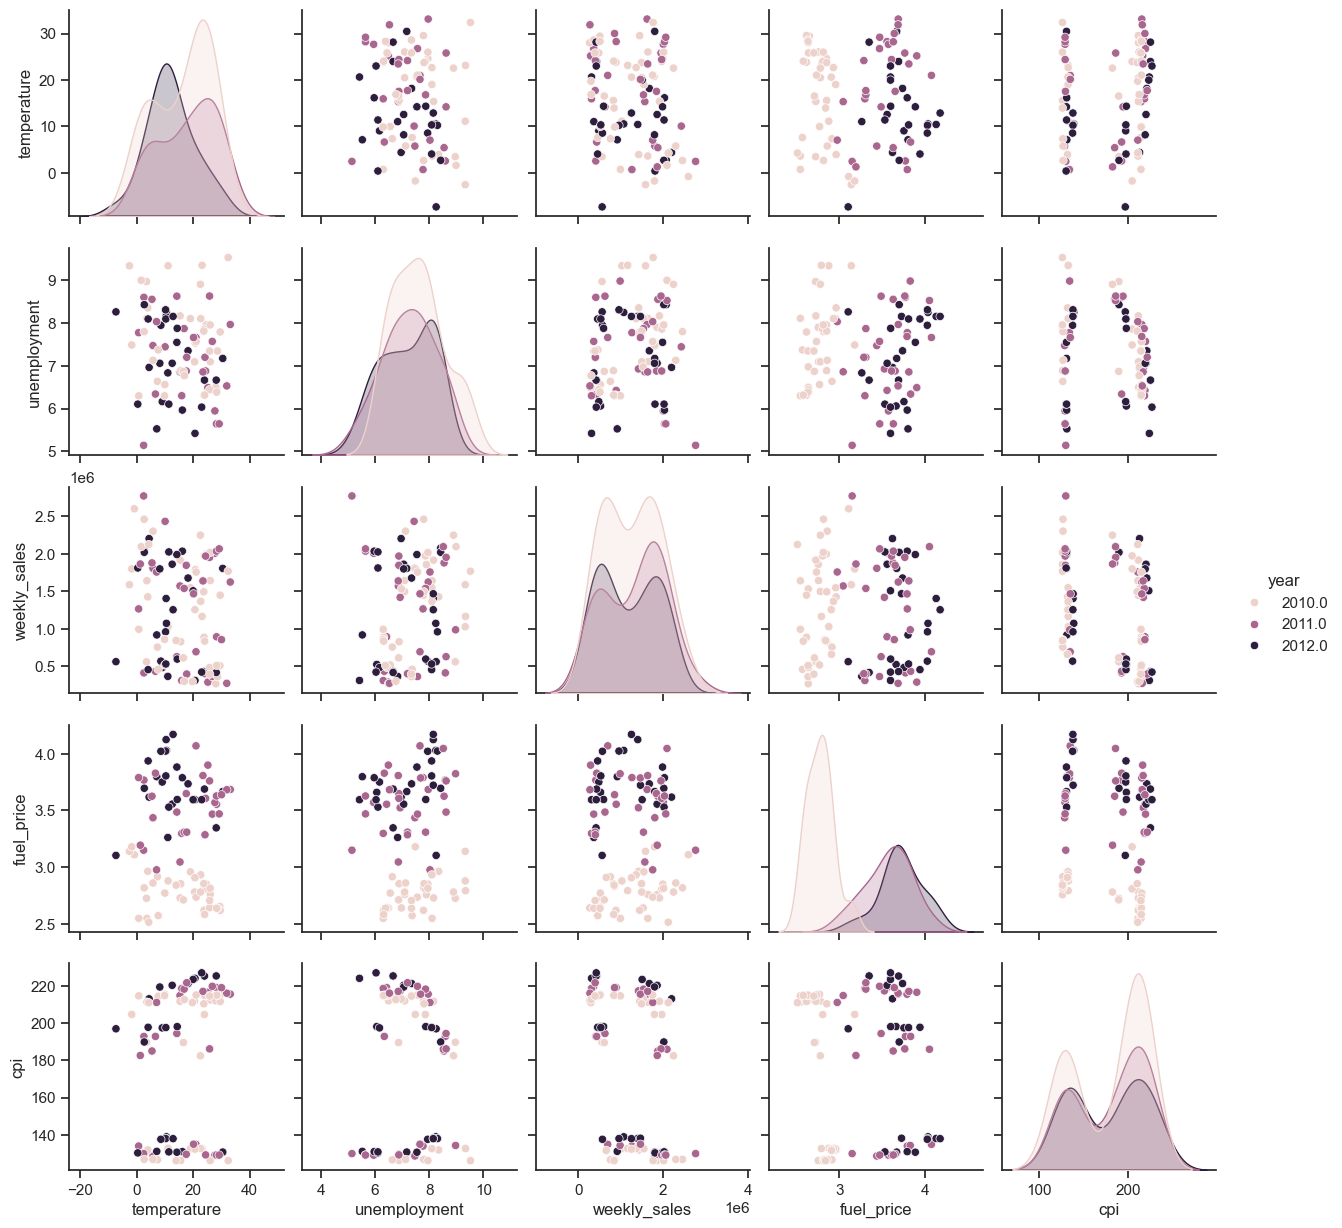

In [65]:
# Same question
tmp_df = df[["year", "temperature", "unemployment", "weekly_sales", "fuel_price", "cpi"]]
sns.set(style="ticks")
_ = sns.pairplot(tmp_df, hue="year")

### Splitting the dataset

In [66]:
X = df.drop(columns=k_target)
y = df[k_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=k_test_size, random_state=k_random_state) 


In [67]:
display(X_train)

,store,holiday_flag,fuel_price,cpi,unemployment,year,month,day,weekday,temperature
89,2,0,3.786,215.154482,7.931,NaN,NaN,NaN,NaN,24.677778
51,2,0,2.728,211.660898,8.163,2010.0,11.0,12.0,4.0,15.383333
0,6,0,3.045,214.777523,6.858,2011.0,2.0,18.0,4.0,15.338889
13,1,0,3.734,221.211813,7.348,2012.0,3.0,16.0,4.0,18.188889
46,5,0,2.640,211.927001,6.496,2010.0,7.0,30.0,4.0,28.033333
...,...,...,...,...,...,...,...,...,...,...
81,5,0,3.630,221.434215,5.943,NaN,NaN,NaN,NaN,NaN
120,8,0,2.582,214.878556,6.315,2010.0,9.0,17.0,4.0,24.066667
15,6,0,2.780,211.894272,7.092,2010.0,4.0,30.0,4.0,20.505556
104,3,0,3.346,225.306861,6.664,2012.0,6.0,22.0,4.0,28.166667


# Part 2 : Baseline model

* Note that the preprocessing is part of the pipeline
* The idea is to have one and only one pipeline
* This avoid any data leakage between train and test
* More importantly, doing so, we are sure that the data (train, test, validation) all go thru the exact same process

With this baseline model the objective is to get data quickly.
* This initial result (R²) will be our reference point
* At this point, the preprocessing is very basic and straightforward

### Preprocessing with sklearn

1. 12% of the ``dates`` are missing. 
    * The dataset is very small. 
    * Can't drop. 
    * Fill with median ? At least the distribution does'nt have a nice gaussian shape
1. 12% of ``temperatures`` are missing. 
    * If for the same store, a date with the same month is available, replace with the temp 
    * Indeed, temp in april in Florida are not the same as temp in april in Alaska. 
    * If no month is available on the row then replace with the average temp for the store (as today Florida is still warmer than Alaska)
1. 10% of the ``unemployement`` values are missing. 
    * Fill with mean of the year
1.  9% of ``fuel_price`` values are missing. 
    * Replace with the median of the fuel_price for the store 
    * Not the average because outliers may not have been replaced yet
1.  8% of ``cpi`` (Consumer Price Index) values are missing. 
    * No way to know where the store is located
    * Replace with the median of the cpi for the store. 
    * It seems there are 2 modes. We could find which mode correspond to the store then apply the median of the mode  

In [68]:
# -----------------------------------------------------------------------------
def get_Transformer(X):
  numeric_features      = X.select_dtypes(include="number").columns
  categorical_features  = X.select_dtypes(exclude="number").columns

  numerical_transformer = make_pipeline(
      SimpleImputer(strategy="median"),
      StandardScaler(),
  )

  categorical_transformer = make_pipeline(
      SimpleImputer(strategy="most_frequent"),
      # OneHotEncoder(drop="first"),                 
      OneHotEncoder(),                 
  )

  col_transformer = make_column_transformer(
    (numerical_transformer,     numeric_features),
    (categorical_transformer, categorical_features),
  )
  return col_transformer



# -----------------------------------------------------------------------------
def get_LinearRegEstimator(X):
  col_transformer = get_Transformer(X)
  model = make_pipeline(
    col_transformer,
    LinearRegression(),
  )
  return model


In [69]:
model = get_LinearRegEstimator(X)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print(f"R² score on training set : {r2_score(y_train, y_train_pred):.4f}" )

y_test_pred = model.predict(X_test)
print(f"R² score on test set     : {r2_score(y_test, y_test_pred):.4f}" )


R² score on training set : 0.9777
R² score on test set     : 0.8977


### <span style="color:orange"><b>Comments :</b></span>

Let's remember :
* If R² is 0, then the regression line (model) explains none of the data variability with respect to the mean.
* If R² is 1, then the regression line explains all data variability with respect to the mean. 

Here, the baseline model is overfitting since R² on test set is lower than R² on train set. The baseline model is not able to generalize correctly.

We can "see" how the dataset is processed with the code below : 

In [70]:
# 1 - This line is here to display the Pipeline
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['fuel_price', 'cpi', 'unemployment', 'year', 'month', 'day', 'weekday',
       'temperature'],
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  Index(['store', 'holiday_flag'], dtype='object'))])),
                ('linearregression', LinearRegression())])

In [71]:
# 2 - Get access to the processed data

model.fit(X_train, y_train)

numeric_features_transformed = model.named_steps["columntransformer"].transformers_[0][2]

categorical_features  = X.select_dtypes(exclude="number").columns
categorical_features_transformed = model.named_steps["columntransformer"].transformers_[1][1].named_steps["onehotencoder"].get_feature_names_out(input_features=categorical_features)

X_train_processed = model.named_steps["columntransformer"].transform(X_train)

X_train_processed_df = pd.DataFrame(X_train_processed, columns=list(numeric_features_transformed) + list(categorical_features_transformed))

display(X_train_processed_df.sort_values(by="cpi", ascending=False))


,fuel_price,cpi,unemployment,year,month,day,weekday,temperature,store_1,store_10,...,store_20,store_3,store_4,store_5,store_6,store_7,store_8,store_9,holiday_flag_0,holiday_flag_1
18,0.592129,1.155121,-1.466266,1.457800,1.238879,0.360788,0.0,0.589254,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
102,0.033383,1.112298,-0.793579,1.457800,-0.154023,0.765702,0.0,1.134982,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
40,0.803911,1.110450,-0.793579,1.457800,-0.502248,-0.718981,0.0,0.692389,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
43,0.504262,1.082026,-0.613128,0.139442,-0.154023,0.090846,0.0,-0.195746,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
71,0.592129,1.079122,-2.119733,1.457800,1.238879,0.360788,0.0,0.337606,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44,-1.077348,-1.440444,-0.557605,-1.178917,1.238879,-2.068693,0.0,-0.198692,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
90,-1.165215,-1.442902,0.580623,-1.178917,0.194203,-1.933722,0.0,0.906319,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
91,-0.493820,-1.443182,1.913183,0.139442,-0.154023,0.090846,0.0,1.473263,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
93,0.308250,-1.443227,2.260204,-1.178917,-0.154023,1.170615,0.0,1.584059,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


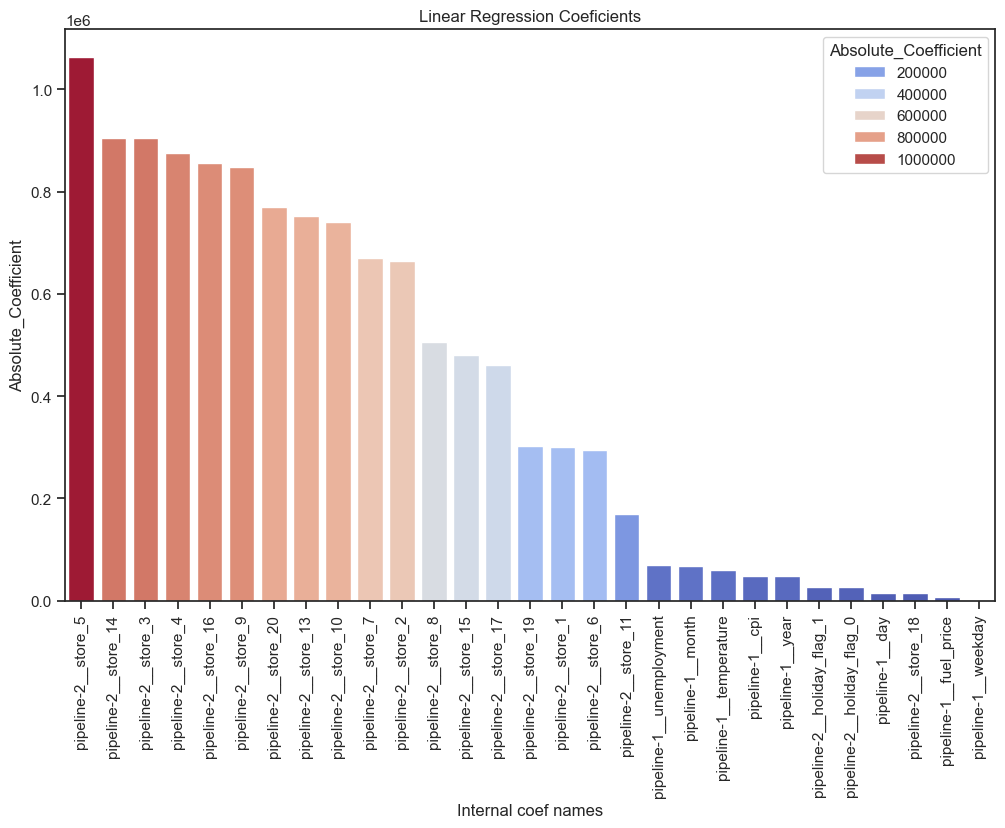

In [72]:
coefficients   = model.named_steps["linearregression"].coef_

feature_names   = model.named_steps["columntransformer"].get_feature_names_out(input_features=X_train.columns)
coefficients_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

coefficients_df["Absolute_Coefficient"] = coefficients_df["Coefficient"].abs()
coefficients_df = coefficients_df.sort_values(by="Absolute_Coefficient", ascending=False)

fig, ax = plt.subplots(figsize=(k_Width, k_Height))
sns.barplot (data=coefficients_df, x = "Feature", y = "Absolute_Coefficient", palette="coolwarm", hue="Absolute_Coefficient") 
plt.xticks(rotation=90)
ax.set_title("Linear Regression Coeficients")
_ = ax.set_xlabel("Internal coef names")



### <span style="color:orange"><b>Comments :</b></span>: 
* The graph shows that the ``pipeline-2__store_5`` coefficient is 10 times greater than the ``pipeline-1__unemployment`` coefficient
* The first non-store coefficient is ``unemployment``
* It is followed by coefficients related to month and temperature
* All other parameters are neglected by this model (year, fuel_price...)

Metrics we could track include :

* R² : The proportion of the variance in the dependent variable that is predictable 
* MSE : Mean Squared Error. average of the squares of the errors between predicted values and actual values
* sqrt(MSE) : Easy to understand because it is in the unit of the target 
* MAE : Mean absolute error. Average of the absolute differences between predictions and actual values
* MAPE : Mean Absolute Percentage Error. Average of the absolute percentage differences between predictions and actual values. 
    * The lower the better (0% => no error in prediction)
    * Easy to understand because it "speaks" in % of prediction.

,MSE,RMSE,MAE,R2,MAPE
Training,1.001413e+10,100070.611,77220.078,0.978,7.937
Testing,3.552378e+10,188477.527,145802.667,0.898,15.069


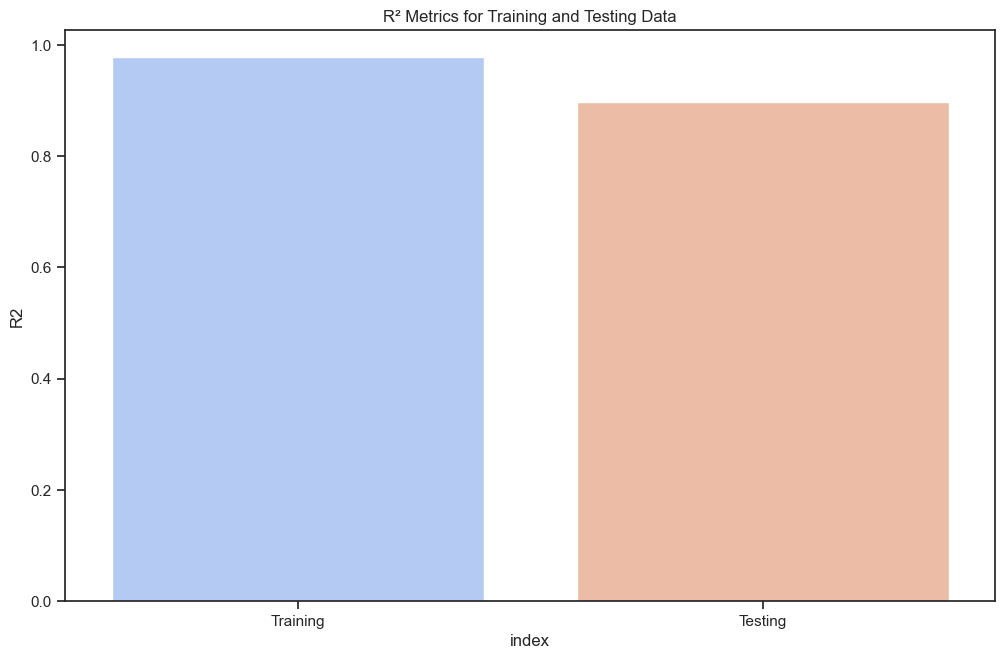

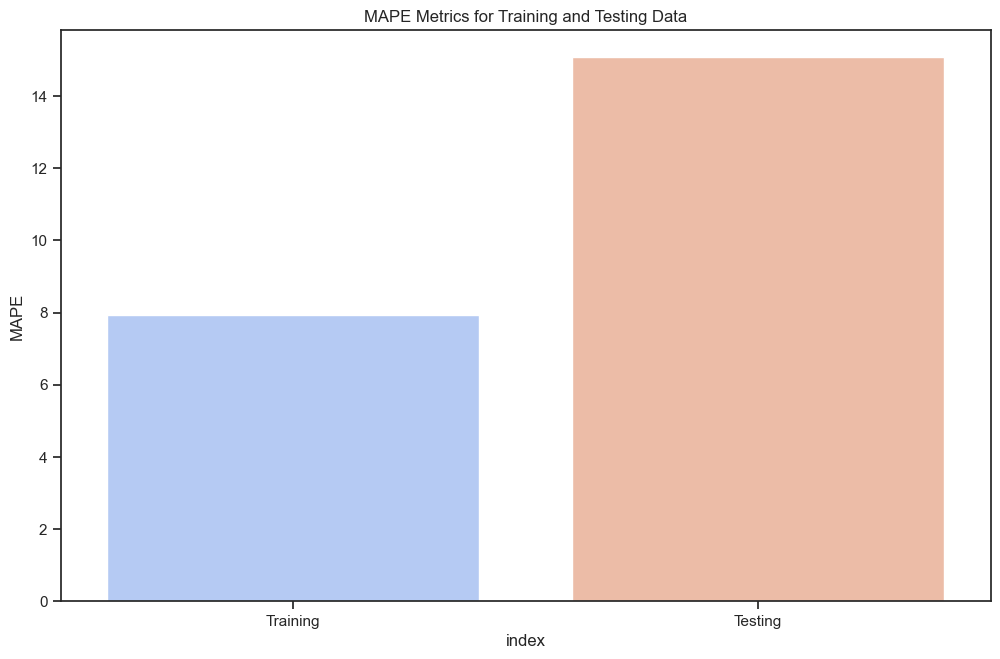

In [73]:
train_metrics = {
    "MSE" : mean_squared_error(y_train, y_train_pred),
    "RMSE": mean_squared_error(y_train, y_train_pred, squared=False),
    "MAE" : mean_absolute_error(y_train, y_train_pred),
    "R2"  : r2_score(y_train, y_train_pred),
    "MAPE": np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
}

test_metrics = {
    "MSE" : mean_squared_error(y_test, y_test_pred),
    "RMSE": mean_squared_error(y_test, y_test_pred, squared=False),
    "MAE" : mean_absolute_error(y_test, y_test_pred),
    "R2"  : r2_score(y_test, y_test_pred),
    "MAPE": np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
}

train_df    = pd.DataFrame(train_metrics, index=["Training"])
test_df     = pd.DataFrame(test_metrics,  index=["Testing"])
metrics_df  = pd.concat([train_df, test_df])
display(metrics_df.round(3))

fig, ax = plt.subplots(figsize=(k_Width, k_Height))
# sns.barplot(data=metrics_df["R2"].transpose(), palette="coolwarm")                                              # => warnings 
sns.barplot(data=metrics_df["R2"].transpose().reset_index(), x= 'index', y="R2", palette="coolwarm", hue='index') # no warning
plt.title('R² Metrics for Training and Testing Data')
plt.show()

fig, ax = plt.subplots(figsize=(k_Width, k_Height))
sns.barplot(data=metrics_df["MAPE"].transpose().reset_index(), x= 'index', y="MAPE", palette="coolwarm", hue='index')
plt.title('MAPE Metrics for Training and Testing Data')
plt.show()

### <span style="color:orange"><b>Comments :</b></span>
* This is where MAPE stands out, because we "understand" that even if the difference in R² is not so big...
* The % error in test predictions is double that of training

# Part 3 : Regularized Regression Model

* It was supposed to be done in a "Part 4" but in order to improve the results ``GridSearchCV`` was implemented upfront
* Read https://scikit-learn.org/stable/modules/linear_model.html


In [74]:

col_transformer = get_Transformer(X)

model = make_pipeline(
  col_transformer,
  Ridge(),
)

model_params = {
  "ridge__alpha"  : [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 1, 2, 5, 10], 
  "ridge__solver" : ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "saga", "sag"] # , "lbfgs"
}

grid = GridSearchCV(model, param_grid=model_params, scoring='r2', n_jobs=-1) # defaults cv=5, refit=true 
grid.fit(X_train, y_train)

best_params = grid.best_params_
print(best_params)                        

model.set_params(**best_params)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_metrics = {
    "MSE" : mean_squared_error(y_train, y_train_pred),
    "RMSE": mean_squared_error(y_train, y_train_pred, squared=False),
    "MAE" : mean_absolute_error(y_train, y_train_pred),
    "R2"  : r2_score(y_train, y_train_pred),
    "MAPE": np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
}

test_metrics = {
    "MSE" : mean_squared_error(y_test, y_test_pred),
    "RMSE": mean_squared_error(y_test, y_test_pred, squared=False),
    "MAE" : mean_absolute_error(y_test, y_test_pred),
    "R2"  : r2_score(y_test, y_test_pred),
    "MAPE": np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
}

train_df    = pd.DataFrame(train_metrics, index=["Training - Ridge"])
test_df     = pd.DataFrame(test_metrics,  index=["Testing - Ridge"])
metrics_df  = pd.concat([metrics_df, train_df, test_df])
display(metrics_df.round(3))




{'ridge__alpha': 0.02, 'ridge__solver': 'auto'}


,MSE,RMSE,MAE,R2,MAPE
Training,1.001413e+10,100070.611,77220.078,0.978,7.937
Testing,3.552378e+10,188477.527,145802.667,0.898,15.069
Training - Ridge,1.003195e+10,100159.620,77143.764,0.978,7.933
Testing - Ridge,3.607755e+10,189940.921,147770.998,0.896,15.329


In [75]:

col_transformer = get_Transformer(X)
model = make_pipeline(
  col_transformer,
  Lasso(),
)

model_params = {
  "lasso__alpha" : [0.001, 0.01, 0.1, 1, 2, 5, 100, 200, 500, 1000, 2000, 5000, 10000], 
}

grid = GridSearchCV(model, param_grid=model_params, scoring='r2', n_jobs=-1) # defaults cv=5, refit=true 
grid.fit(X_train, y_train)

best_params = grid.best_params_
print(best_params)                        

model.set_params(**best_params)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_metrics = {
    "MSE" : mean_squared_error(y_train, y_train_pred),
    "RMSE": mean_squared_error(y_train, y_train_pred, squared=False),
    "MAE" : mean_absolute_error(y_train, y_train_pred),
    "R2"  : r2_score(y_train, y_train_pred),
    "MAPE": np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
}

test_metrics = {
    "MSE" : mean_squared_error(y_test, y_test_pred),
    "RMSE": mean_squared_error(y_test, y_test_pred, squared=False),
    "MAE" : mean_absolute_error(y_test, y_test_pred),
    "R2"  : r2_score(y_test, y_test_pred),
    "MAPE": np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
}

train_df    = pd.DataFrame(train_metrics, index=["Training - Lasso"])
test_df     = pd.DataFrame(test_metrics,  index=["Testing - Lasso"])
metrics_df  = pd.concat([metrics_df, train_df, test_df])
display(metrics_df.sort_values(by="R2", ascending=False).round(3))




{'lasso__alpha': 200}


,MSE,RMSE,MAE,R2,MAPE
Training,1.001413e+10,100070.611,77220.078,0.978,7.937
Training - Ridge,1.003195e+10,100159.620,77143.764,0.978,7.933
Training - Lasso,1.004213e+10,100210.451,77148.333,0.978,7.917
Testing - Lasso,3.541807e+10,188196.883,146798.222,0.898,15.269
Testing,3.552378e+10,188477.527,145802.667,0.898,15.069
Testing - Ridge,3.607755e+10,189940.921,147770.998,0.896,15.329


### <span style="color:orange"><b>Comments :</b></span>
* Thanks to the composite estimator the fine tuning Lasso and Ridge was not too difficult
* However results are somewhat disapointing
* Can we get a better understanding of the data and run one or two test to get improved results ? 

# Part 4 : Bonus - Any chance to get better results ?

## Some of the ideas
* The model is overfitting
* Fundamentally this means
  * The model is too complex
  * We need more data

## PCA analysis

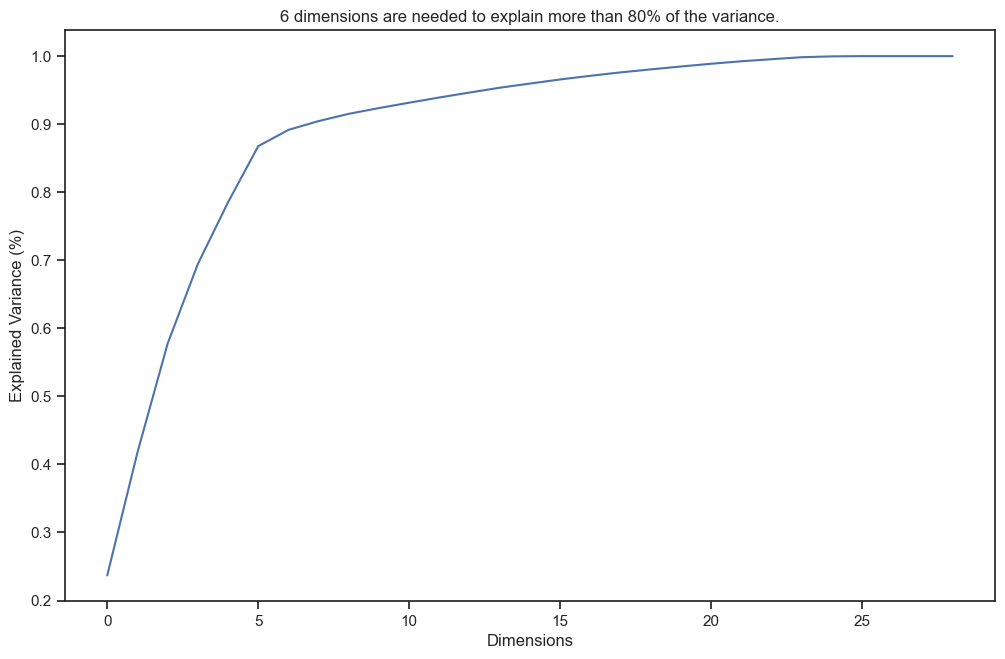

In [76]:

col_transformer = get_Transformer(X)
X_tmp = col_transformer.fit_transform(X_train)

pca = PCA()
pca.fit(X_tmp)
cum_sum= np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cum_sum>=.8) + 1

fig, ax = plt.subplots(figsize=(k_Width, k_Height))
sns.lineplot (cum_sum)
ax.set_title(f"{d} dimensions are needed to explain more than 80% of the variance.")
ax.set_xlabel("Dimensions")
ax.set_ylabel("Explained Variance (%)")
plt.show()


### <span style="color:orange"><b>Comments :</b></span>

* 6 dimensions are needed to understand 80% of the variance
* However, if one watch again the chart "Linear Regression Coeficients", most of the first coeficients are related to stores
* May be we could try to <span style="color:orange"><b>split the stores in 3 categories</b></span> according their revenue

At this point we will :
* Work with the data before the train_test_split happens
* Split the store in 3 groups and create a group_id feature and drop the store 
* Use the "Linear Regression Coeficients" chart and remove, one after the other the less important


In [77]:
df2 = df.copy()
df2["store"] = df2["store"].astype("int")
df2["group_id"] = pd.qcut(df2["weekly_sales"], q=3, labels=[0, 1, 2])
df2.drop(columns=["store"], inplace=True)
df2["group_id"] = df2["group_id"].astype("str")
quick_View(df2)


,name,dtype,# null,% null,# NOT null,distinct val,-3*sig,min,max,+3*sig,distinct val count
0,weekly_sales,float64,0,0.00,131,131,-715248.52,268929.03,2771397.17,3231229.40,"{1572117.54: 1, 1468350.36: 1, 1256282.79: 1, ..."
1,holiday_flag,object,0,0.00,131,2,1.00,1.00,-1.00,-1.00,"{'0': 123, '1': 8}"
2,fuel_price,float64,12,9.16,119,108,1.88,2.51,4.17,4.73,"{3.594: 3, 3.786: 2, 2.548: 2, 3.3080000000000..."
3,cpi,float64,11,8.40,120,119,61.01,126.11,226.97,299.35,"{126.7934: 2, 214.7775231: 1, 210.3374261: 1, ..."
4,unemployment,float64,14,10.69,117,96,4.42,5.14,9.52,10.38,"{6.832999999999998: 3, 8.15: 3, 5.644: 2, 6.10..."
5,year,float64,18,13.74,113,3,2008.36,2010.00,2012.00,2013.30,"{2010.0: 49, 2011.0: 34, 2012.0: 30}"
6,month,float64,18,13.74,113,12,-3.27,1.00,12.00,15.81,"{6.0: 14, 2.0: 12, 5.0: 12, 7.0: 12, 3.0: 10, ..."
7,day,float64,18,13.74,113,30,-8.19,1.00,31.00,41.25,"{12.0: 10, 19.0: 7, 25.0: 7, 18.0: 6, 16.0: 6,..."
8,weekday,float64,18,13.74,113,1,4.00,4.00,4.00,4.00,{4.0: 113}
9,temperature,float64,14,10.69,117,116,-15.00,-7.34,33.14,46.56,"{20.505555555555553: 2, 15.33888888888889: 1, ..."


In [78]:
X = df2.drop(columns=k_target)

# In order to drop the lines below the graph "Linear Regression Coeficients" (see the next cell) was updated
# The features were dropped in order : from least to "most" important
X = X.drop(columns="weekday")
X = X.drop(columns="cpi")
X = X.drop(columns="fuel_price")
X = X.drop(columns="month")
X = X.drop(columns="day")
X = X.drop(columns="unemployment")
X = X.drop(columns="holiday_flag")
X = X.drop(columns="year")
X = X.drop(columns="temperature")

y = df2[k_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=k_test_size, random_state=k_random_state) 

model = get_LinearRegEstimator(X)


model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print(f"R2   train set : {r2_score(y_train, y_train_pred):>7.4f}" )
print(f"MAPE train set : {np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100:.4f}")

y_test_pred = model.predict(X_test)
print(f"R2   test set  : {r2_score(y_test, y_test_pred):>7.4f}" )
print(f"MAPE test set  : {np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100:.4f}")

R2   train set :  0.8845
MAPE train set : 18.6516
R2   test set  :  0.8784
MAPE test set  : 20.0331


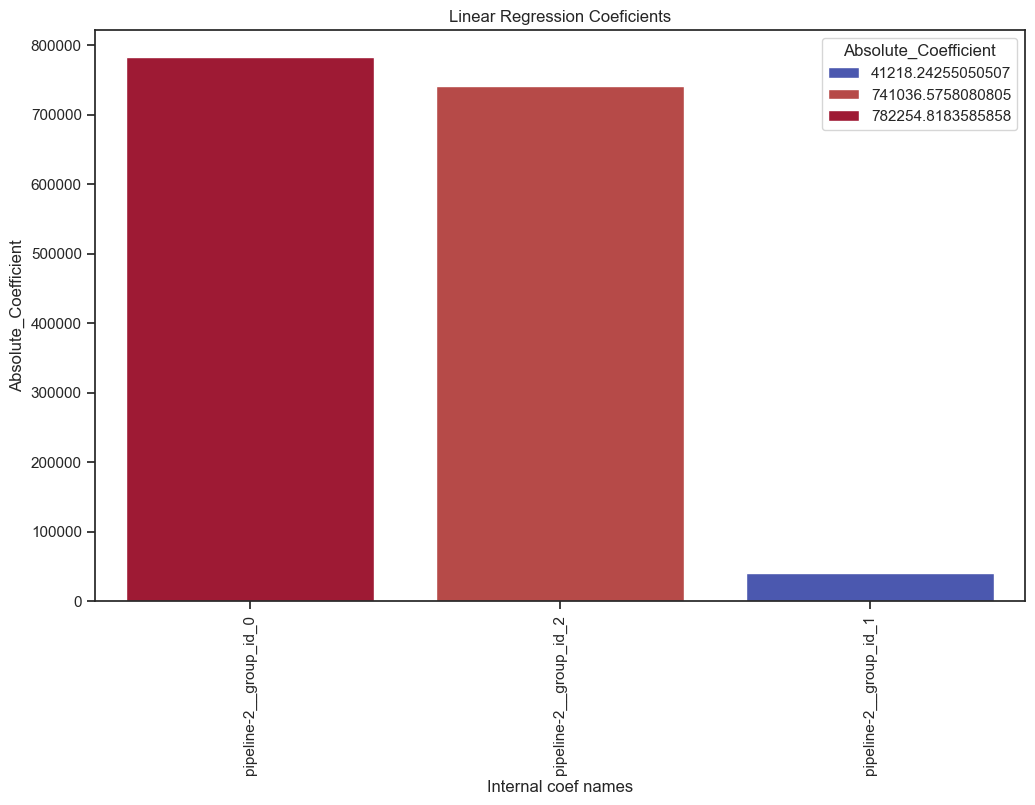

In [79]:
coefficients   = model.named_steps["linearregression"].coef_

feature_names   = model.named_steps["columntransformer"].get_feature_names_out(input_features=X_train.columns)
coefficients_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

coefficients_df["Absolute_Coefficient"] = coefficients_df["Coefficient"].abs()
coefficients_df = coefficients_df.sort_values(by="Absolute_Coefficient", ascending=False)

fig, ax = plt.subplots(figsize=(k_Width, k_Height))
sns.barplot (data=coefficients_df, x = "Feature", y = "Absolute_Coefficient", palette="coolwarm", hue="Absolute_Coefficient") 
plt.xticks(rotation=90)
ax.set_title("Linear Regression Coeficients")
_ = ax.set_xlabel("Internal coef names")
